In [2]:
import librosa
import librosa.display
import playsound
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.io import wavfile
from scipy import signal
from scipy.signal import spectrogram, lfilter, butter
from utils.utils import plot_spectrogram

import warnings
## Librosa load can't read mp3, therefore it will call audioread instead.
warnings.filterwarnings("ignore", message="PySoundFile failed. Trying audioread instead.")
rng = np.random.default_rng() 

# Load & Visualize Audio

## Load Audio

Length of the Audio: 8505303
Sample Rate: 22050


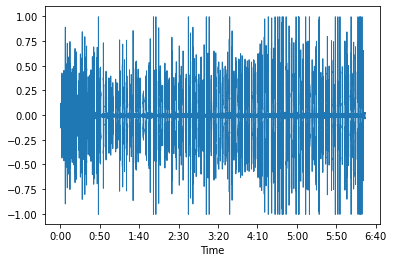

In [13]:
filename = 'test.mp3'
filepath = filename # '11-2-22/' + filename
audio, sr = librosa.load(filepath)
print("Length of the Audio:", audio.shape[0])
print("Sample Rate:", sr)

librosa.display.waveshow(audio, sr=sr)
plt.show()

## Fourier Transform

In [116]:
def fft_plot(audio, sr):
  n = len(audio)
  T = 1/sr
  yf = scipy.fft.fft(audio)
  xf = np.linspace(0.0, 1.0/(2.0*T), n//2)
  plt.plot(xf, 2/n * np.abs(yf[:n//2])) ## consider only the positive frequency
  plt.grid()
  plt.xlabel("Frequncy -->")
  plt.ylabel("Magnitude")

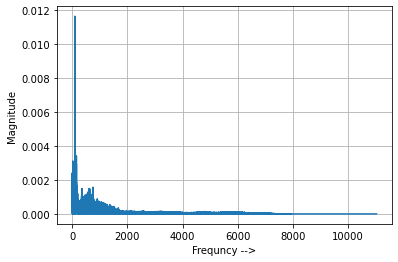

In [117]:
fft_plot(audio, sr)

## Mel-Spectrogram

In [118]:
S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128,
                                    fmax=sr/2)

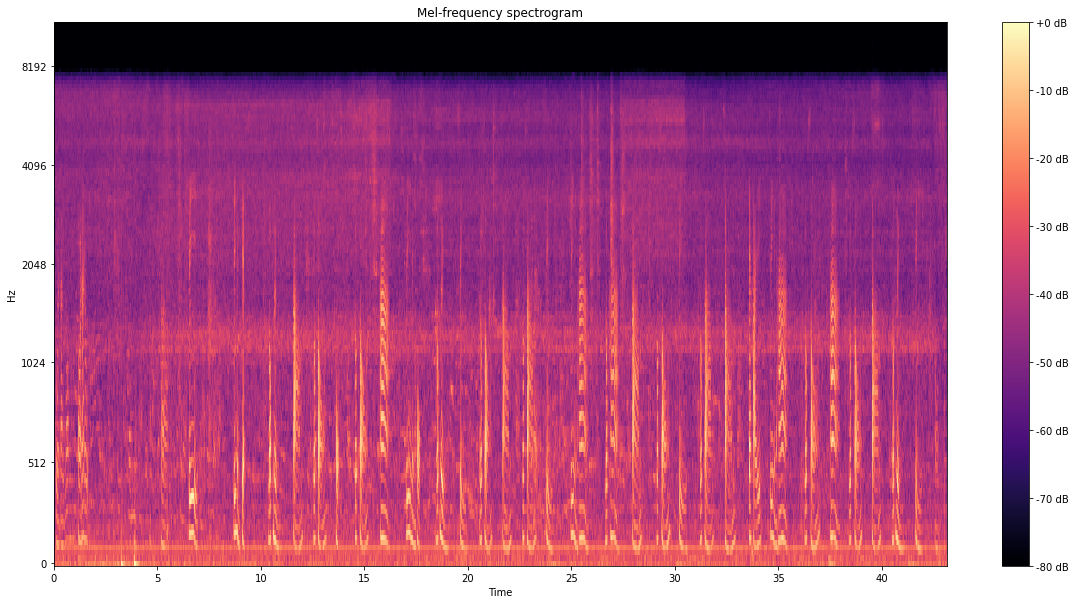

In [119]:
fig, ax = plt.subplots(figsize=(20, 10))
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=sr/2, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')
plt.show()

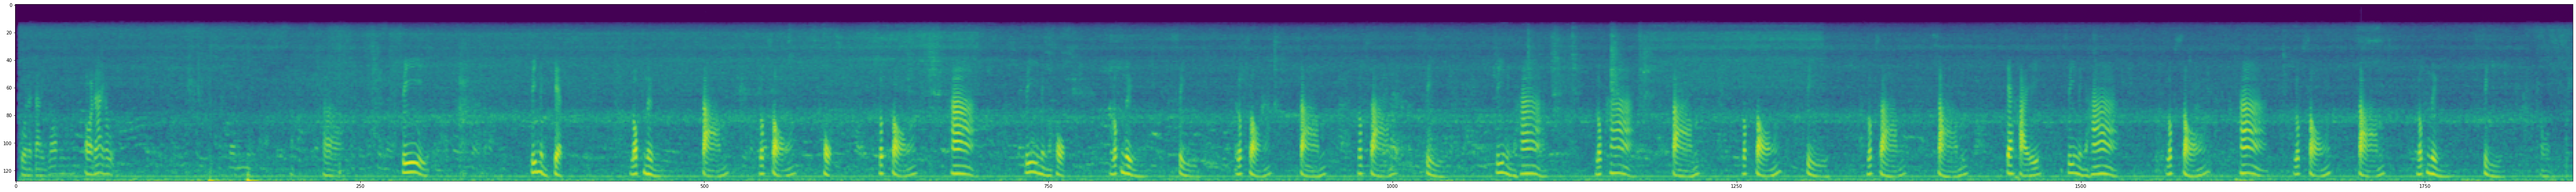

In [120]:
plt.figure(figsize=(100, 70))
plt.imshow(S_dB[::-1, ])

## Power Spectrogram

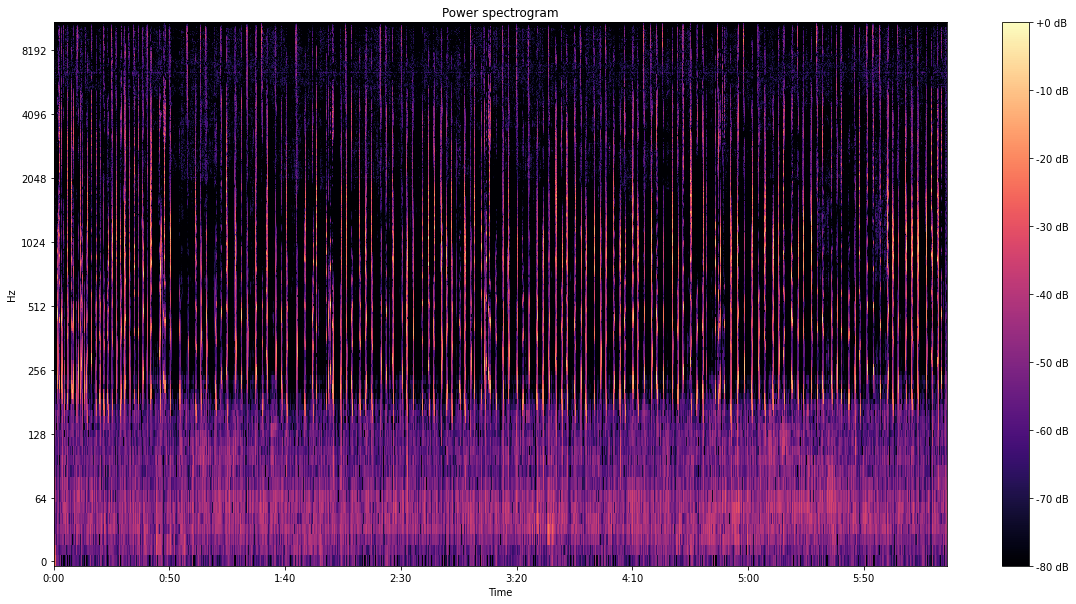

In [14]:
S = np.abs(librosa.stft(audio))
fig, ax = plt.subplots(figsize=(20, 10))
img = librosa.display.specshow(librosa.amplitude_to_db(S,
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")
plt.show()

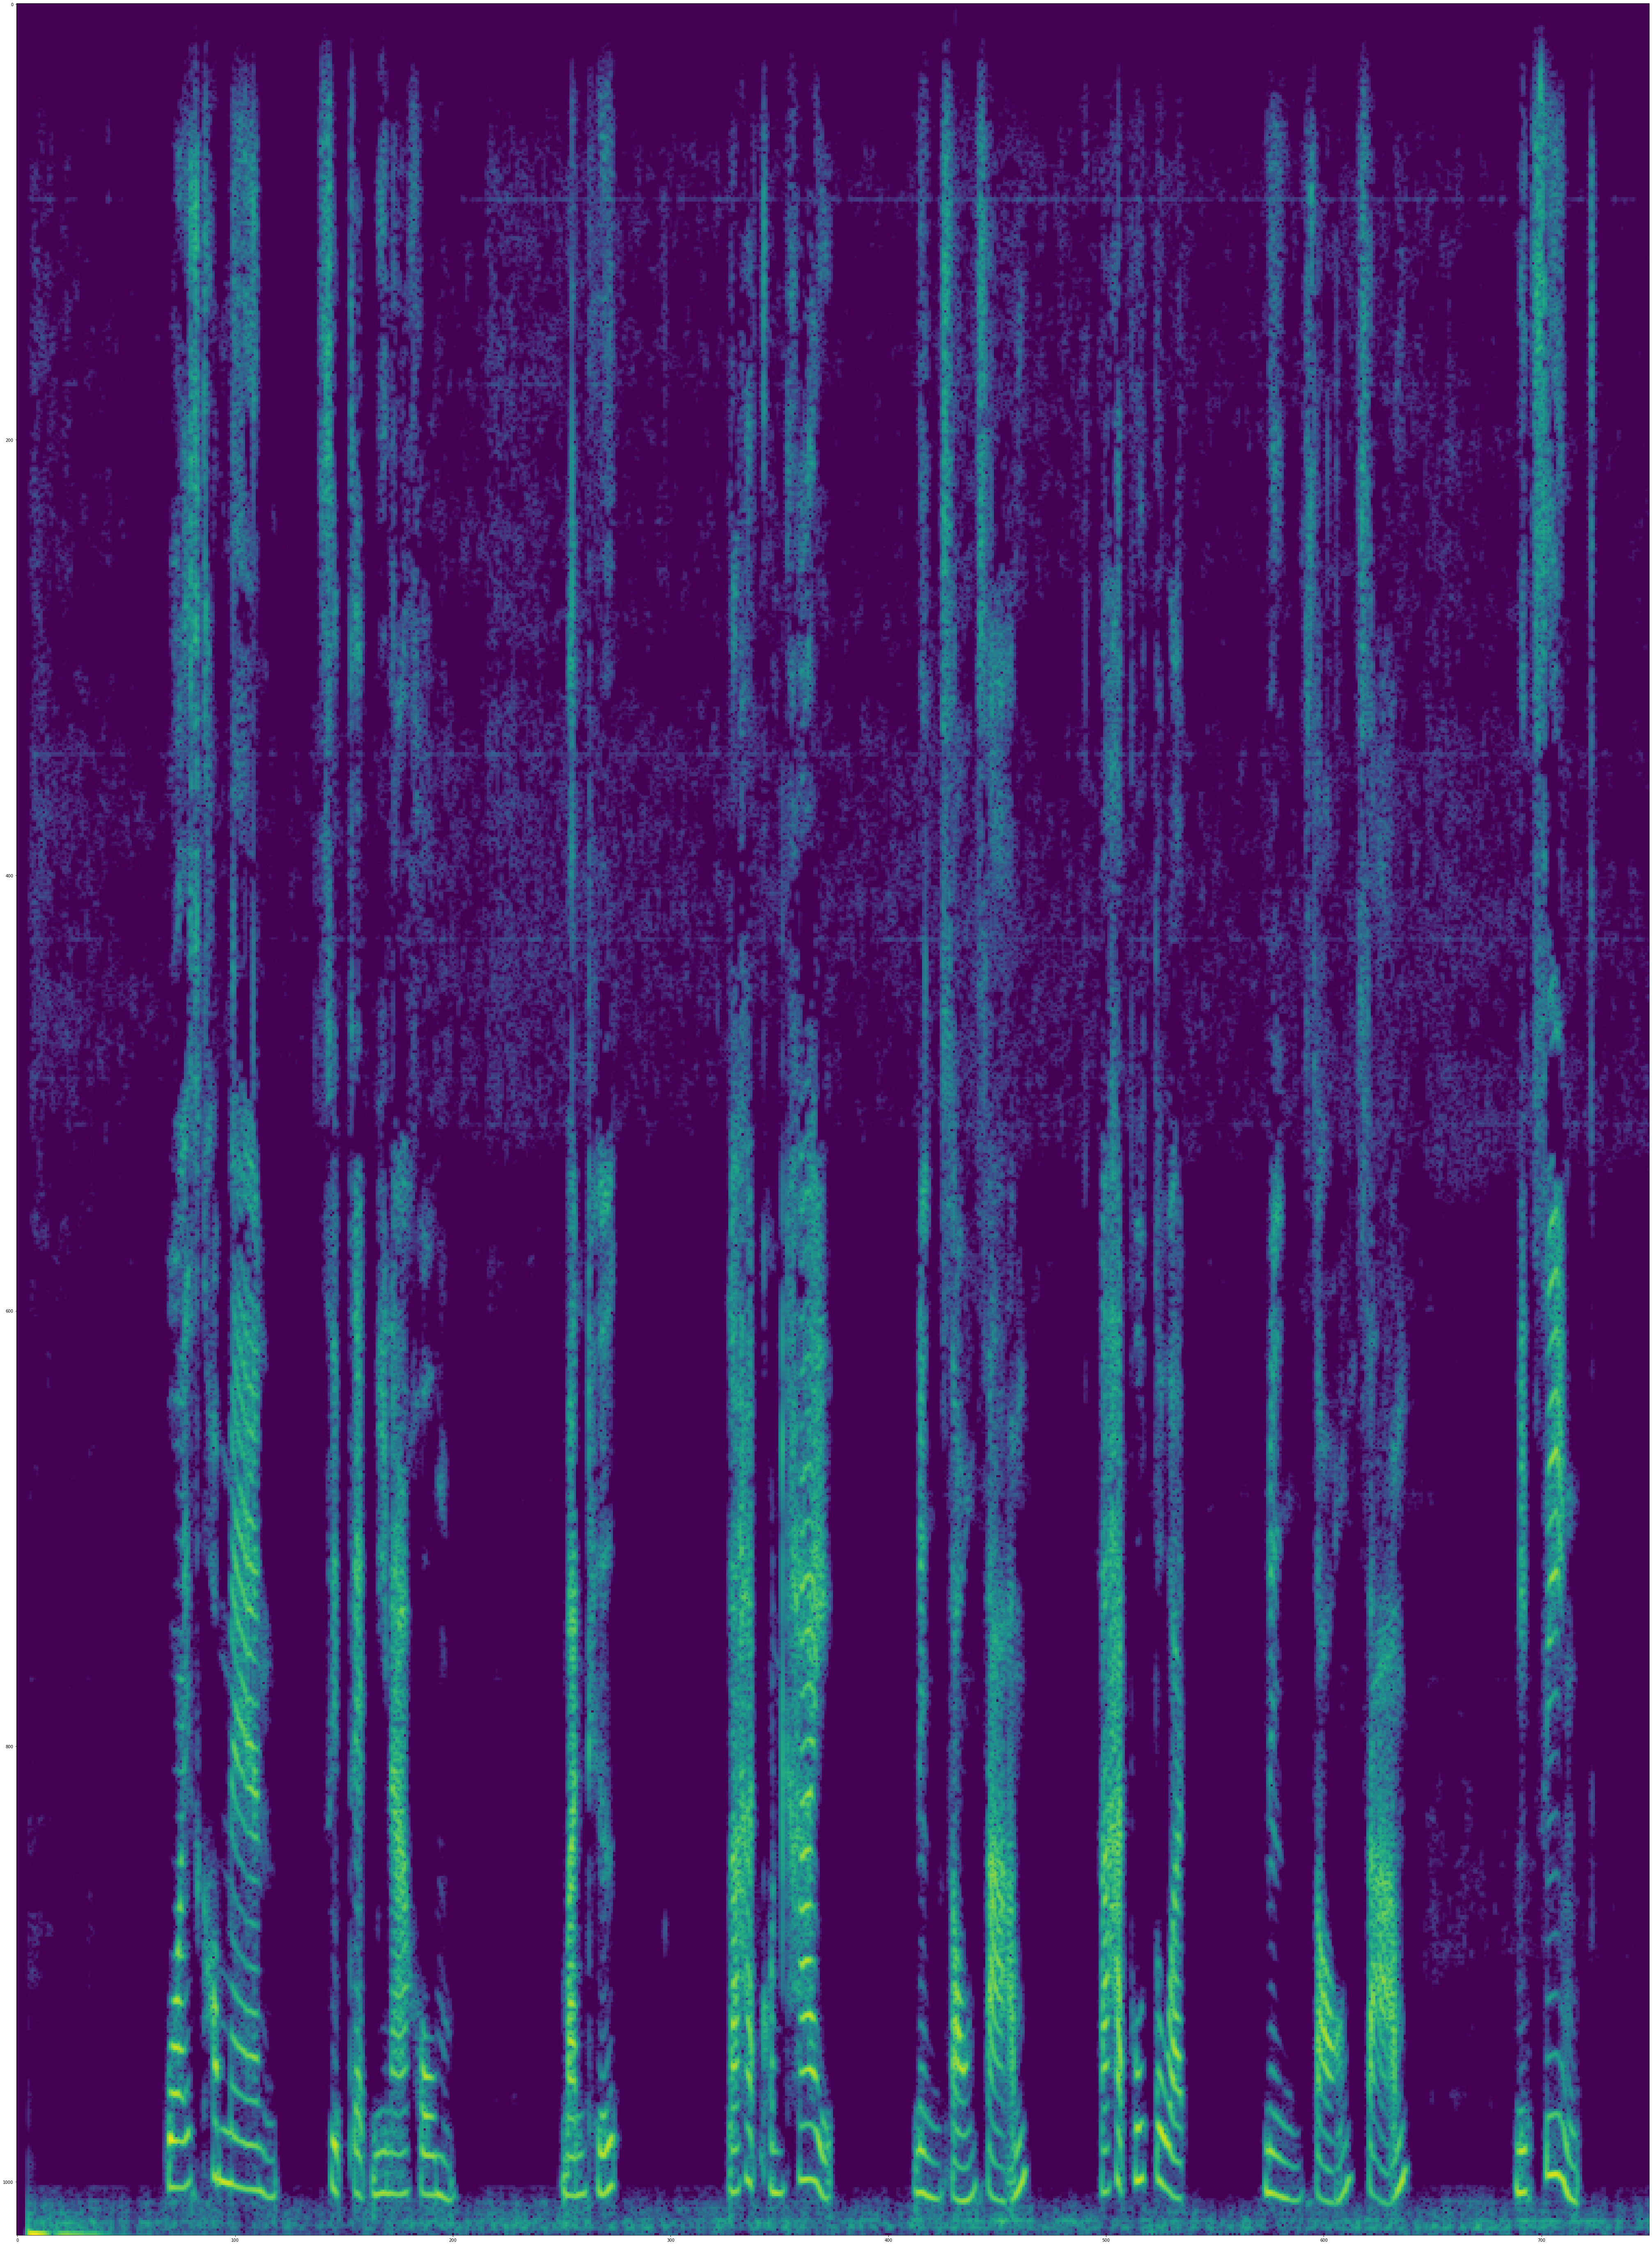

In [15]:
plt.figure(figsize=(100, 100))
plt.imshow(librosa.amplitude_to_db(S,ref=np.max)[::-1, :750])

# Denoise

## Preprocessing

### High-pass Filter

In [130]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [131]:
cutoff = 800

denoise_audio = butter_lowpass_filter(audio, cutoff, sr)

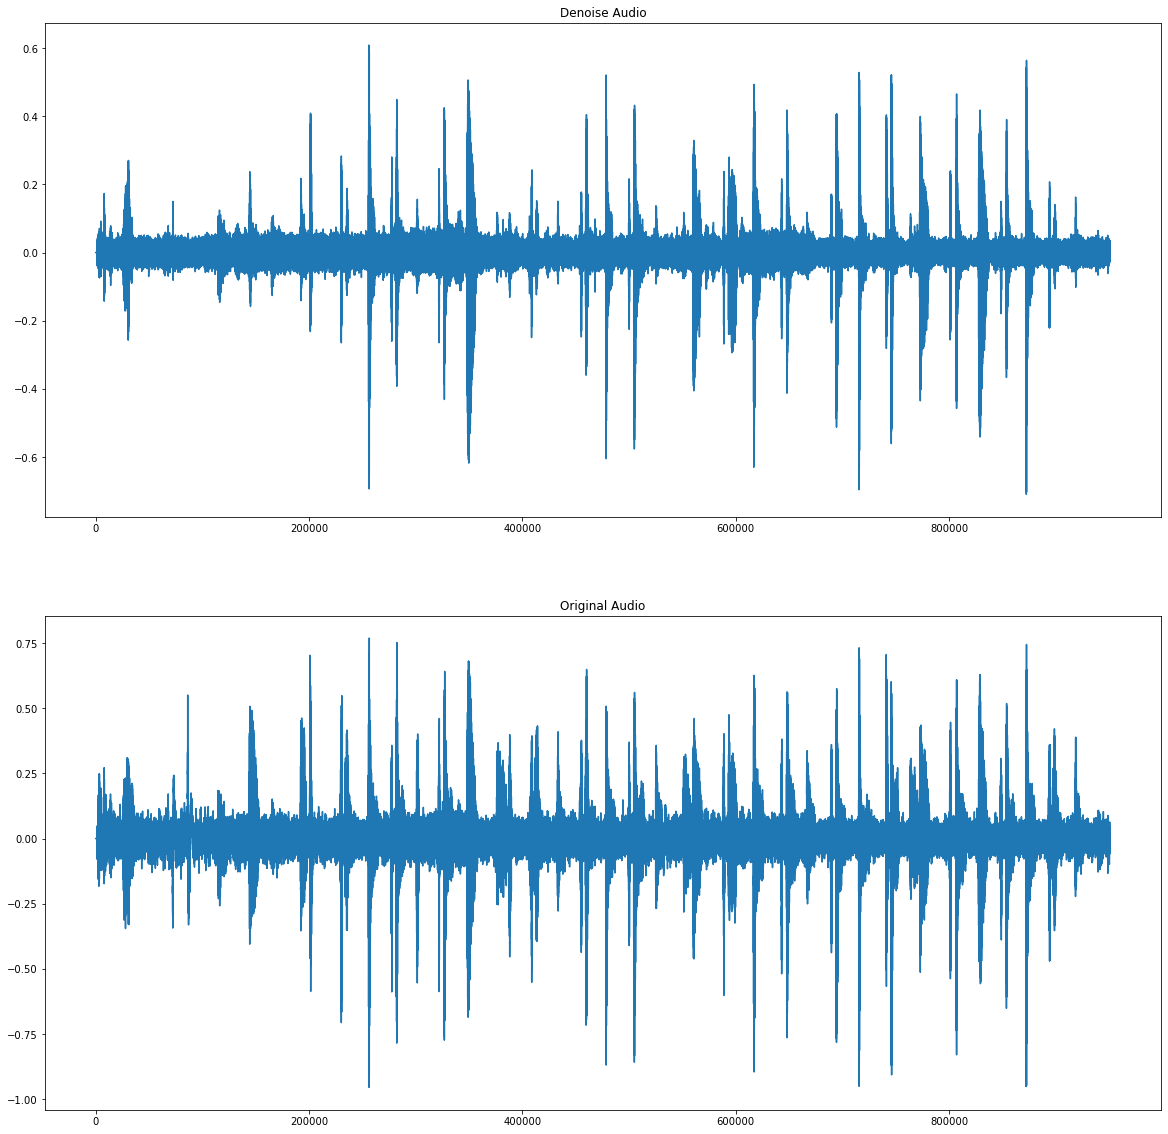

In [132]:
fig, ax = plt.subplots(nrows=2, figsize=(20, 20))
ax[0].set_title("Denoise Audio")
ax[0].plot(denoise_audio)
ax[1].set_title("Original Audio")
ax[1].plot(audio)
plt.show()

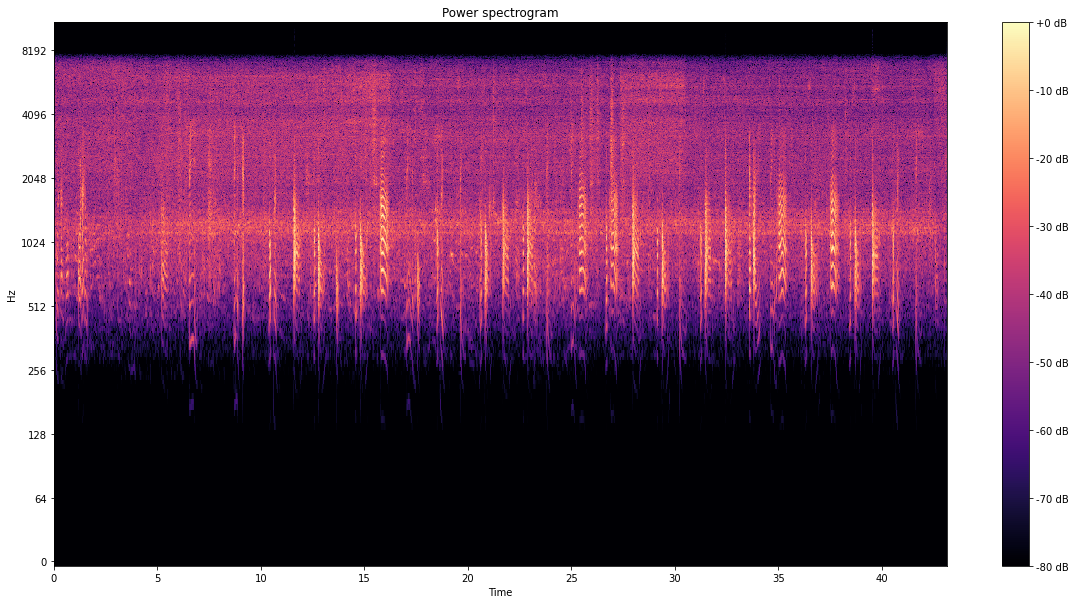

In [133]:
plot_spectrogram(denoise_audio)

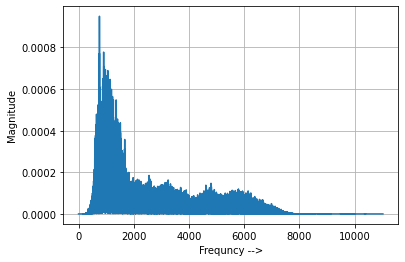

In [134]:
fft_plot(denoise_audio, sr)

In [135]:
wavfile.write('high-pass.wav', sr, denoise_audio.astype('f4'))

### Spectral Gating

In [40]:
import noisereduce as nr
# perform noise reduction
reduced_noise = nr.reduce_noise(y=audio, sr=sr)

100%|██████████| 11/11 [00:02<00:00,  4.97it/s]


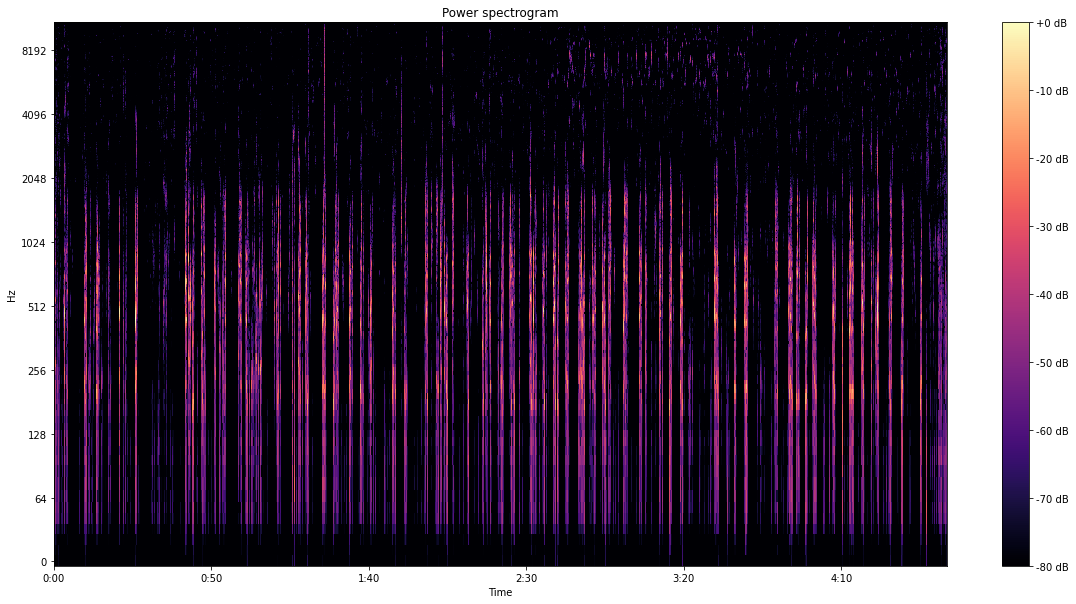

In [41]:
plot_spectrogram(reduced_noise)

In [42]:
wavfile.write(f'spectral-gate/{filename.split(".")[0]}.wav', sr, reduced_noise.astype('f4'))